In [66]:
# Imports
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import History

import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display
from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import seaborn as sns
from sklearn.metrics import pairwise_distances
from scipy import spatial
import scipy

In [2]:
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

In [3]:
def my_gen(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except:
            pass

In [4]:
batch_size = 16
img_dim = 100 # to resize images to img_dim x img_dim

# Augment training image dataset with slightly transformed images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1)

test_datagen = ImageDataGenerator(
    rescale=1./255)

train_gen = train_datagen.flow_from_directory('data/dl-images',
                                              target_size=(img_dim, img_dim),
                                              shuffle = True,
                                              batch_size = batch_size)

# Testing images are only available for 20 of the characters, and not for all characters in the training dataset
test_gen = test_datagen.flow_from_directory('data/dl-images', 
                                            target_size=(img_dim, img_dim),
                                            shuffle = True,
                                            batch_size = batch_size)

Found 13285 images belonging to 2671 classes.
Found 13285 images belonging to 2671 classes.


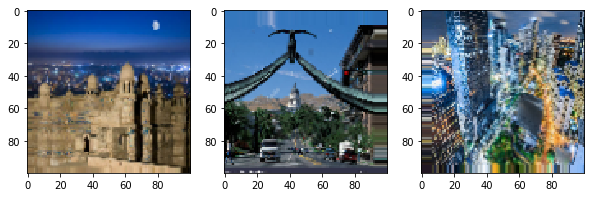

In [5]:
# Preview some augmented training images
plt.figure(figsize=(10,3))
x,y = train_gen.next()
for i in range(0,3):
    image = x[i]
    plt.subplot(1,3,i+1)
    plt.imshow(image)

In [6]:
# 5 convolutional layers, 2 dense layers, and an output layer
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_dim, img_dim, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dense(200)) #19
model.add(Activation('relu'))
model.add(Dense(2671))
model.add(Activation('softmax'))

opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [7]:
history = History()

# Train new model, else load trained model
train_new_model = False;
if train_new_model == True:
    model.fit_generator(my_gen(train_gen),
                        steps_per_epoch = 20000//batch_size,
                        epochs = 50,
                        validation_data = my_gen(test_gen),
                        validation_steps = 1500//batch_size,
                        callbacks=[history])
    # Save the model and scores during training epochs
    model.save('CNN_5c3d.h5')
    history_df = pd.DataFrame(history.history)
    history_df.to_csv("history.csv")
else:
    model = keras.models.load_model('CNN_5c3d.h5')
    history_df = pd.read_csv('history.csv')

Text(0.5,0,'Epoch')

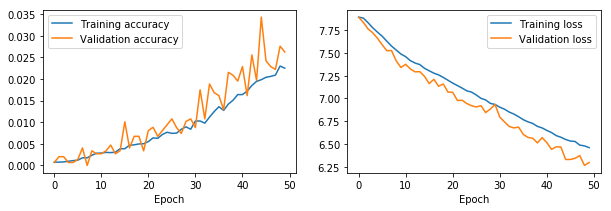

In [8]:
plt.figure(figsize=(10,3))
# Training history
ax = plt.subplot(1,2,1)
history_df['acc'].plot()
history_df['val_acc'].plot()
ax.legend(['Training accuracy','Validation accuracy'])
ax.set_xlabel('Epoch')
ax = plt.subplot(1,2,2)
history_df['loss'].plot()
history_df['val_loss'].plot()
ax.legend(['Training loss','Validation loss']);
ax.set_xlabel('Epoch')

In [9]:
# For getting CNN outputs
from keras import backend as K
input_shape = (img_dim, img_dim, 3)
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function([inp, K.learning_phase()], outputs )   # evaluation function

In [140]:
# Get activation of 
def get_img_activation(my_index):
    folder_path = 'data/dl-images/'+str(my_index)+'/'
    img_list = [f for f in glob.glob(folder_path+'*.jpg')] # get all image file names for a given city
    try:
        img=plt.imread(img_list[0]) # get first image
    except(OSError):
        try:
            img=plt.imread(img_list[1])
        except(OSError):
            try: 
                img=plt.imread(img_list[2])
            except(OSError):
                    img=plt.imread(img_list[3])
        
    if my_index == 1828:
        img=plt.imread(img_list[3])
    
    try:
        img = img[:,:,:3]
    except(IndexError):
        img = img
    

        
    
    res = cv2.resize(img, dsize=(100, 100), interpolation=cv2.INTER_CUBIC) # resize
    
    try:
        res_formatted = (res/255)[np.newaxis,...] # Make img format consistent for feding into CNN
        layer_outs = functor([res_formatted, 1.]) # Get layer outputs for this image
    except(InvalidArgumentError):
        res_formatted = (res/255) # Make img format consistent for feding into CNN
        layer_outs = functor([res_formatted, 1.]) # Get layer outputs for this image
    
    
    specific_layer_out = layer_outs[21][0] # Get activation in the [19] layer
    
    
    return specific_layer_out

In [141]:
outputs = []
for i in np.arange(2671):
    outputs.append(get_img_activation(i))

/home/sam/anaconda3/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [142]:
len(outputs[6])

2671

In [143]:
len(outputs)

2671

In [144]:
outputs_array = np.array(outputs)

In [145]:
outputs_array.shape

(2671, 2671)

In [146]:
sims_df = pd.DataFrame(1-pairwise_distances(outputs_array, metric="cosine"))

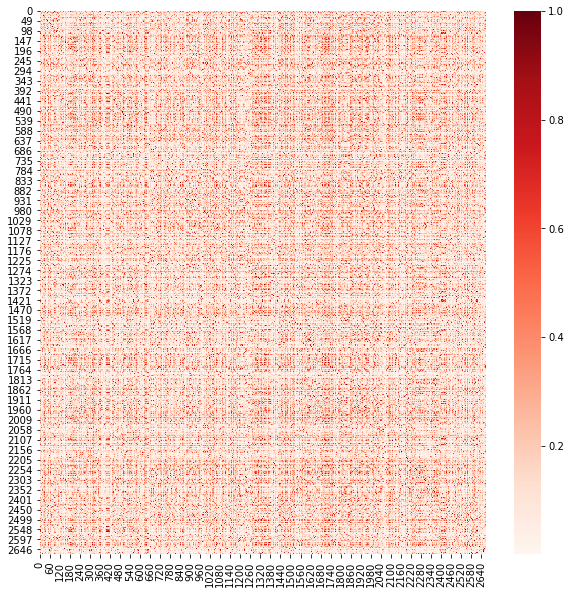

In [147]:
plt.figure(figsize=(10,10))
sns.heatmap(sims_df.values,cmap='Reds')

In [148]:
idx = np.argsort(-sims_df, axis=1)

In [149]:
# Sorted index of images similarities
idx.head()

,0,1,2,3,4,5,6,7,8,9,...,2661,2662,2663,2664,2665,2666,2667,2668,2669,2670
0,0,2078,1845,2408,149,1374,668,1275,1268,2615,...,1733,469,737,432,932,1654,1126,960,591,2573
1,1,558,2582,805,2114,1542,260,2311,2241,1317,...,2402,1358,1915,2561,707,1897,2185,1607,2142,2509
2,2,500,1740,1708,723,1021,367,207,447,2447,...,791,2349,2338,2290,2142,1134,449,1563,813,2573
3,3,415,2031,812,219,2449,2399,1867,605,4,...,351,2187,2314,2161,229,2338,1563,196,602,2573
4,4,605,2449,2423,1709,2634,219,3,2380,812,...,1539,2312,2520,229,602,2314,2161,2338,2573,351


In [150]:
idx.iloc[0].head()

0       0
1    2078
2    1845
3    2408
4     149
Name: 0, dtype: int64

In [151]:
idx[idx.iloc[0]==2078].index

Int64Index([1], dtype='int64')

In [152]:
# Get immage similarities of recommended cities
cities = pd.read_csv('cities_narrow.csv', index_col=0)

In [153]:
cities.head()

,Country,City,Lat,Lon,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10
0,Afghanistan,Herat,34.340000,62.189999,1209,2624,1201,2210,599,1219,1055,962,1754,1232
1,Afghanistan,Kabul,34.516667,69.183334,233,1744,1742,1628,2607,2310,1746,885,2362,2015
2,Afghanistan,Jalalabad,34.420000,70.449997,1062,2637,995,1754,1,1193,1072,1099,991,1211
3,Afghanistan,Kandahar,31.610000,65.699997,2000,1741,1220,1037,1980,929,2628,1133,1111,1002
4,Afghanistan,Kunduz,36.720000,68.860001,0,1776,1777,1778,1779,1780,1781,1782,1783,1784


In [154]:
top_cities_idx = cities.loc[:,'s1':'s10']

In [155]:
top_cities_idx.head()

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10
0,1209,2624,1201,2210,599,1219,1055,962,1754,1232
1,233,1744,1742,1628,2607,2310,1746,885,2362,2015
2,1062,2637,995,1754,1,1193,1072,1099,991,1211
3,2000,1741,1220,1037,1980,929,2628,1133,1111,1002
4,0,1776,1777,1778,1779,1780,1781,1782,1783,1784


In [156]:
top_cities_idx.values[0]

array([1209, 2624, 1201, 2210,  599, 1219, 1055,  962, 1754, 1232])

In [157]:
# Collect image ranking for NLP-suggested cities
agg_rank = []
# For each city
for counter, suggested_city_idxs in enumerate(top_cities_idx.values):
    city_rank = []
    for city_idx in suggested_city_idxs:
        img_rank = idx[idx.iloc[counter]==city_idx].index
        city_rank.append(img_rank)
    agg_rank.append(np.mean(city_rank))

In [158]:
np.mean(agg_rank)

1309.6744290527893

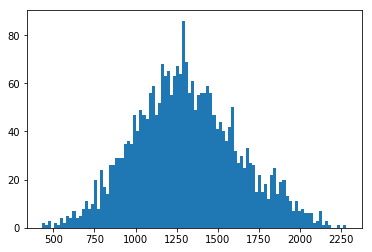

In [159]:
plt.hist(agg_rank, bins=100);

In [160]:
# Collect image ranking for random cities
rand_rank = []
# For each city
for counter in np.arange(len(cities)):
    city_rank = []
    for num in np.arange(10):
        img_rank = idx[idx.iloc[counter]==np.random.randint(0,len(cities))].index
        city_rank.append(img_rank)
    rand_rank.append(np.mean(city_rank))

In [161]:
np.mean(rand_rank)

1335.0548109322351

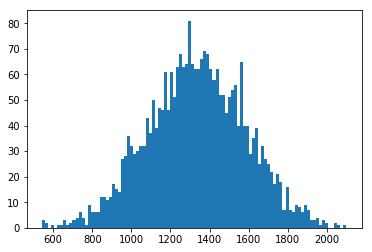

In [162]:
plt.hist(rand_rank, bins=100);

In [163]:
scipy.stats.ttest_ind(agg_rank,rand_rank)

Ttest_indResult(statistic=-3.2617350957111366, pvalue=0.001114280630490601)